In [6]:
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# torch.multiprocessing.set_start_method('spawn')
import gym_lite6.env, gym_lite6.pickup_task
%env MUJOCO_GL=egl # Had to export this before starting jupyter server
# import mujoco

env: MUJOCO_GL=egl # Had to export this before starting jupyter server


""

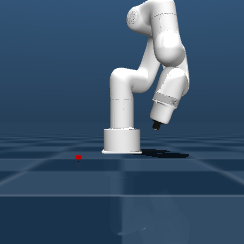

In [7]:
from importlib import reload

reload(gym_lite6.env)

task = gym_lite6.pickup_task.PickupTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.render(), width=400, height=400)



In [8]:
import torchvision


class MLPPolicy(torch.nn.Module):
  def __init__(self, hidden_layer_dims, state_dims=9):
    """
    state_dims: 6 for arm, 3 for gripper
    """
    super().__init__()

    # self.img_feature_extractor = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', )
    
    self.img_feature_extractor = self._create_img_feature_extractor()
    # Resnet output is 1x512, 2 bits for gripper
    self.actor = self._create_actor(512 + state_dims, hidden_layer_dims, state_dims)

    self.sigmoid = torch.nn.Sigmoid()
  
  def _create_actor(self, input_size, hidden_layer_dims, output_size):
    actor = []
    actor.append(torch.nn.Linear(input_size, hidden_layer_dims[0]))
    actor.append(torch.nn.ReLU())
    for i in range(len(hidden_layer_dims) - 1):
      actor.append(torch.nn.Linear(hidden_layer_dims[i], hidden_layer_dims[i+1]))
      actor.append(torch.nn.ReLU())
    actor.append(torch.nn.Linear(hidden_layer_dims[-1], output_size))
    return torch.nn.Sequential(*actor)

  def _create_img_feature_extractor(self):
    """
    ResNet18 backbone with last fc layer chopped off
    Weights frozen
    Ouput shape [1, 512, 1, 1]
    """
    resnet = torchvision.models.resnet18(weights='DEFAULT')
    modules = list(resnet.children())[:-1]
    backbone = torch.nn.Sequential(*modules)
    backbone.requires_grad_(False)
    return backbone

  def forward(self, state, image):
    img_features = torch.squeeze(self.img_feature_extractor(image), dim=[2, 3])
    input = torch.hstack((state, img_features))
    out = self.actor(input)
    # Gripper sigmoid
    out[:, 6:8] = self.sigmoid(out[:, 6:8])
    return out

  
  def predict(self, state, image, episode_start=None, deterministic=None):
    return self.forward(state, image)


In [9]:
# gripper_embedding = torch.tensor([[0, 1.]])
# # def encode_gripper(gripper):
# #   return {-1: [0, 1], 0: [0, 0], 1: [1, 0]}[gripper]

jnt_range_low = env.unwrapped.model.jnt_range[:6, 0]
jnt_range_high = env.unwrapped.model.jnt_range[:6, 1]
bounds_centre = torch.tensor((jnt_range_low + jnt_range_high) / 2, dtype=torch.float32)
bounds_range = torch.tensor(jnt_range_high - jnt_range_low, dtype=torch.float32)

def normalize_qpos(qpos):
    return (qpos - bounds_centre) / bounds_range + 0.5

def unnormalize_qpos(qpos):
    return (qpos - 0.5) * bounds_range + bounds_centre

qpos = torch.tensor([0, 1, 2, -0.5, -0.1, 1])
qpos_recalc = unnormalize_qpos(normalize_qpos(qpos))
assert torch.allclose(qpos, qpos_recalc), qpos_recalc


def embed_gripper(gripper):
  """
  Convert from (-1, 1) to one hot encoded
  One hot needs them as 1d
  """
  return torch.nn.functional.one_hot(gripper.flatten() + 1, num_classes=3)

def decode_gripper(gripper):
  """
  Convert from one hot encoded to column vector in range (-1, 1)
  """
  return (torch.argmax(gripper, dim=1) - 1).unsqueeze(1).to(int)

cats = torch.tensor(([[-1], [0], [1]]))
embedded = embed_gripper(cats)
assert embedded.equal(torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])), embedded
decoded = decode_gripper(embedded)
assert decoded.equal(cats), decoded



In [10]:
# Reset the policy and environmens to prepare for rollout
def evaluate_policy(policy, env, n, visualise=False):
  avg_reward = 0
  for i in range(n):
    numpy_observation, info = env.reset()

    # Prepare to collect every rewards and all the frames of the episode,
    # from initial state to final state.
    rewards = []
    frames = []
    action = {}

    # Render frame of the initial state
    frames.append(env.render())

    step = 0
    done = False
    while not done and len(frames) < 300:
      # Prepare observation for the policy running in Pytorch
      # Get qpos in range (-1, 1), gripper is already in range (-1, 1)
      qpos_normalised = normalize_qpos(torch.from_numpy(numpy_observation["state"]["qpos"]).unsqueeze(0))
      gripper = embed_gripper(torch.tensor(numpy_observation["state"]["gripper"]))
      state = torch.hstack((qpos_normalised, gripper))
      image = torch.from_numpy(numpy_observation["pixels"])
      
      # Convert to float32 with image from channel first in [0,255]
      # to channel last in [0,1]
      state = state.to(torch.float32)
      image = image.to(torch.float32) / 255
      image = image.permute(2, 0, 1)

      # Add extra (empty) batch dimension, required to forward the policy
      # state = state.unsqueeze(0)
      image = image.unsqueeze(0)

      # Send data tensors from CPU to GPU
      state = state.to(device, non_blocking=True)
      image = image.to(device, non_blocking=True)

      # Predict the next action with respect to the current observation
      with torch.inference_mode():
        raw_action = policy.predict(state, image).to("cpu")
      
      action["qpos"] = unnormalize_qpos(raw_action[:, :6]).flatten().numpy()
      action["gripper"] = decode_gripper(raw_action[:, 6:8]).item()
      # print(action)
      # numpy_action = np.hstack((action["qpos"], action["gripper"]))

      # Step through the environment and receive a new observation
      numpy_observation, reward, terminated, truncated, info = env.step(action)
      # Keep track of all the rewards and frames
      rewards.append(reward)
      frames.append(env.render())

      # The rollout is considered done when the success state is reach (i.e. terminated is True),
      # or the maximum number of iterations is reached (i.e. truncated is True)
      done = terminated | truncated | done
      step += 1
    
    avg_reward += rewards[-1]/n

    if visualise:
      media.show_video(frames, fps=env.metadata["render_fps"])
    
  return avg_reward, frames

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

policy = MLPPolicy([128, 128, 128]).to(device)

In [13]:
evaluate_policy(policy, env, 1, visualise=True)[0]

0.0

In [14]:
import time


def preprocess_data(batch):
    """
    Take a batch of data and put it in a suitable tensor format for the model
    """
    out = {}
    
    observation_qpos_normalised = normalize_qpos(torch.tensor(batch["observation.state.qpos"], dtype=torch.float32))
    observation_gripper = embed_gripper(torch.tensor(batch["observation.state.gripper"], dtype=int)).to(torch.float32)
    out["preprocessed.observation.state"] = torch.hstack((observation_qpos_normalised, observation_gripper))

    action_qpos_normalised = normalize_qpos(torch.tensor(batch["action.qpos"], dtype=torch.float32))
    action_gripper = embed_gripper(torch.tensor(batch["action.gripper"], dtype=int)).to(torch.float32)
    out["preprocessed.action.state"] = torch.hstack((action_qpos_normalised, action_gripper))
    
    # Convert to float32 with image from channel first in [0,255]
    tf = torchvision.transforms.ToTensor()
    out["preprocessed.observation.image"] = torch.stack([tf(x) for x in batch["observation.pixels"]])


    return out

In [15]:
import datasets
# datasets.config.IN_MEMORY_MAX_SIZE = 16*1024*1024
from datasets import load_from_disk
# 
dataset = load_from_disk("../dataset/scripted_trajectories_50_2024-07-14_14-25-22.hf")
dataset.set_transform(preprocess_data)


In [16]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()


In [17]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import datetime
writer = SummaryWriter(log_dir=f"../runs/lite6_pick_place/{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

hidden_layer_dims = '_'.join([str(x.out_features) for x in policy.actor[:-1] if 'out_features' in x.__dict__])

n_epoch = 50
step = 0
for epoch in range(n_epoch):
  policy.train()
  end = time.time()
  for batch in tqdm(dataloader):
    data_load_time = time.time()

    # Send data tensors from CPU to GPU
    state = batch["preprocessed.observation.state"].to(device, non_blocking=True)
    image = batch["preprocessed.observation.image"].to(device, non_blocking=True)
    a_hat = batch["preprocessed.action.state"].to(device, non_blocking=True)

    gpu_load_time = time.time()

    a_pred = policy.predict(state, image)

    pred_time = time.time()

    loss = loss_fn(a_pred, a_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_time = time.time()

    writer.add_scalar("Loss/train", loss.item(), step)
    writer.add_scalar("Time/data_load", data_load_time - end, step)
    writer.add_scalar("Time/gpu_transfer", gpu_load_time - data_load_time, step)
    writer.add_scalar("Time/pred_time", pred_time - gpu_load_time, step)
    writer.add_scalar("Time/train_time", train_time - pred_time, step)
    writer.add_scalar("Time/step_time", time.time() - end, step)

    step += 1
    end = time.time()
  
  if epoch % 2 == 0 or epoch == n_epoch-1:
    # Evaluate
    policy.eval()
    print(f"Epoch: {epoch+1}/{n_epoch}, steps: {step}, loss: {loss.item()}")
    avg_reward, frames = evaluate_policy(policy, env, 5, visualise=False)
    media.show_video(frames)
    print("avg reward: ", avg_reward)
    writer.add_scalar("Reward/val", avg_reward, step)
    # _, frames = evaluate_policy(policy, env, 1, visualise=True)
    writer.add_images("Image", np.stack([frames[x].transpose(2, 0, 1) for x in range(0, len(frames), 50)], axis=0), step)
  
    writer.add_scalar("Time/eval_time", time.time() - end, step)


  if epoch % 10 == 0 or epoch == n_epoch-1:
    torch.save({
            'epoch': epoch,
            'policy_state_dict': policy.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f'../ckpts/lite6_pick_place_h{hidden_layer_dims}_epoch{epoch}.pt')
  
writer.flush()

writer.close()


 19%|████████▌                                     | 11/59 [00:14<01:04,  1.33s/it]


KeyboardInterrupt: 